# This notebook trains the semantic segmentation models using edges detected from images. 
Inspired by https://expoundai.wordpress.com/2019/08/30/transfer-learning-for-segmentation-using-deeplabv3-in-pytorch/

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/') # mount google drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset 
import torchvision.transforms as transforms

import torchvision.models as models

In [ ]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


# Function to create semantic segmentation models from pretrained models provided by Pytorch

In [ ]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
from torchvision.models.segmentation.fcn import FCNHead

In [ ]:
### create segmentation models

def create_segmentation_model(network_type='DeepLabV3',backbone='Resnet101',outputchannels=5):
    """
    This function creates pretrained semantic segmentation models
    Attributes:
    network_type: options are 'DeepLabV3' and 'FCN'
    backbone: options are 'Resnet101' and 'Resnet50'
    outputchannels: number of classes in training set
    """

    if network_type == 'DeepLabV3':
        if backbone == 'Resnet101':
            print('Creating DeepLabV3-resnet101...')
            model = models.segmentation.deeplabv3_resnet101(pretrained=True, progress=True) 
        if backbone == 'Resnet50':
            print('Creating DeepLabV3-resnet50...')
            model = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)           
        model.classifier = DeepLabHead(2048, outputchannels) # modify the classifier to suit new dataset
    if network_type == 'FCN':
        if backbone == 'Resnet101':
            print('Creating FCN-resnet101...')
            model = models.segmentation.fcn_resnet101(pretrained=True, progress=True)
        if backbone == 'Resnet50':
            print('Creating FCN-resnet50...')
            model = models.segmentation.fcn_resnet50(pretrained=True, progress=True)           
        model.classifier = model.classifier = FCNHead(2048, outputchannels) # modify the classifier to suit new dataset
    
    return model

# training and validation functions

# Load data for training

In [2]:
!ls "/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/" 

image  mask  p169_E12ESDKLNCL01_12.psd	p180_E6ESDRKLIN01_36.psd


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob

### create directory for model saving

In [ ]:
model_base_dir = os.path.join('/content/gdrive/My Drive/acse9/models','segmentation')
if not os.path.exists(model_base_dir):
        os.mkdir(model_base_dir)
else:
    print('Directory exists!')

Directory exists!


In [ ]:
# get the directory list of images and masks
ori_lst = glob.glob('/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/*')
mask_lst = glob.glob('/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/*npy')
print(ori_lst, mask_lst)

['/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p228_E15ESREGMAP01_56.psd', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p220_E17ESREGMAP01_6.psd', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p169_E12ESDKLNCL01_11.tif', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p125_E12ESPWYCOL01_10.psd', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p103_E19ESCOLOR_01_0.tif', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p222_E11ESREGMAP01_44.psd'] ['/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/p222_E11ESREGMAP01_44.npy', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/p169_E12ESDKLNCL01_11.npy', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/p125_E12ESPWYCOL01_10.npy', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/p103_E19ESCOLOR_01_0.n

In [ ]:
# sort the list according to specific order
def get_4chars(x):
    return(x[73:76])
def get_4chars_mask(x):
    return(x[72:75])
ori_lst = sorted(ori_lst, key = get_4chars) 
mask_lst = sorted(mask_lst, key = get_4chars_mask) 


In [ ]:
print(ori_lst)
print(mask_lst)

['/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p103_E19ESCOLOR_01_0.tif', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p125_E12ESPWYCOL01_10.psd', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p169_E12ESDKLNCL01_11.tif', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p220_E17ESREGMAP01_6.psd', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p222_E11ESREGMAP01_44.psd', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/image/p228_E15ESREGMAP01_56.psd']
['/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/p103_E19ESCOLOR_01_0.npy', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/p125_E12ESPWYCOL01_10.npy', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/p169_E12ESDKLNCL01_11.npy', '/content/gdrive/My Drive/acse9/data/Labelled_Image/Labelled_Image/mask/p220_E17ESREGMAP01_6.np

In [ ]:
# load images 
def load_images(dir_list):
  """
  Load the data under the data directory
  """
  all_images = []

  for i in dir_list:
    img_path = i
    img = Image.open(img_path).convert('L') # open the image as grayscale

    img = np.array(img)
    all_images.append(img)
  
  return all_images


In [ ]:
all_images = load_images(ori_lst)

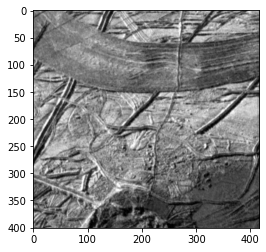

In [ ]:
plt.imshow(all_images[0],cmap='gray')

In [ ]:
# load masks
def load_masks(dir_list):
  """
  Load the mask under the data directory
  """
  all_masks = []

  for i in dir_list:
    data = np.load(i)
    all_masks.append(data)
  
  return all_masks

In [ ]:
all_masks = load_masks(mask_lst)

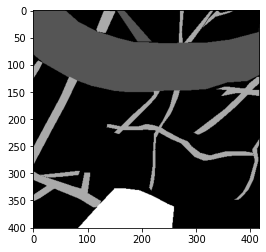

In [ ]:
plt.imshow(all_masks[0],cmap='gray')

# Make Customized dataset

In [ ]:
# print the shape of all masks
for i in range(len(all_masks)):
    print(all_masks[i].shape)

(401, 417)
(536, 797)
(666, 675)
(5700, 3485)
(800, 800)
(800, 800)


In [ ]:
# print the shape of all images
for i in range(len(all_images)):
    print(all_images[i].shape)

(401, 417)
(536, 797)
(666, 675)
(5700, 3485)
(800, 800)
(800, 800)


# Optimize images and extract the edges

In [ ]:
import cv2

In [ ]:
 def auto_optim(original_image):
    """
    This function optimizes the contrast and brightness over the image
    """
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    optimised_image = clahe.apply(original_image)
    return optimised_image

In [ ]:
 def draw_edges(image, low_threshold=100, high_threshold=200):
        """
        Code by Ke Wen: 
        Edge detection using Canny edge algorithm. The default thresholding
            value is based on the optimised Europa satellite image. 
        Attributes:
            image: numpy.array, input images 
            low_threshold: the lower bound value of the hysteresis thresholding
            high_threshold: the upper bound value of the hysteresis thresholding
        """
        image = np.array(image)
        #print(image.shape)
        # no need to optimise the image again as they are optimised after cropping
        # optimised_image = self.auto_optim(image) #optimised contrast and brightness
        # blur the image by Gaussian Noise
        kernel_size = 5
        blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        
        edges = cv2.Canny(blurred_image, low_threshold, high_threshold)
        return edges  

# Crop images and masks

In [ ]:
def label_if_defect(img):
  """
  This function classifies those images into 4 classes:
  perfect images(0), with black defect(1), with white defect(2), black & white defect(3)
  """
  nb_black = len((np.where(img==0))[0]) # count number of black pixels in this image
  nb_white = len((np.where(img==255))[0]) # count number of white pixels in this image
  nb_pixels = img.shape[0]*img.shape[1]  # count number of pixels in this image

  label = 0
  if nb_black/nb_pixels > 0.1:
    label = 1
  if nb_white/nb_pixels > 0.1:
    if label == 1:
      label = 3
    if label == 0:
      label = 2

  return label

In [ ]:
def regular_crop(size,image,mask):
        """
        Original code is from Ke Wen, and I made a few revision to fit the segmentation task
        Crop images regularly into subimages with the size 
        Attribute:
            size: int, sub image dimension: size x size
        """
        h = image.shape[0]
        w = image.shape[1]

        if 0<size<h or 0<size<w: # check input size
            col = int(w/size)
            row = int(h/size)
            # print("number of images generated:", col*row)
            
            # crop from centre, ignore edges:
            start_left = int((w - col*size)/2)
            start_top = int((h - row*size)/2)
            # print("top left axis:", f'[{start_top},{start_left}]')
            cropped_image_set = []
            cropped_mask_set = []
            
            #start to crop:
            left = start_left
            top = start_top
            for j in range(row):
                for i in range(col):
                    cropped_image = image[top:top+size, left:left+size]
                    cropped_mask = mask[top:top+size, left:left+size]
                    if label_if_defect(cropped_image) ==0: #passed defect check
                        cropped_image = auto_optim(cropped_image) 
                        cropped_image_set.append(cropped_image)
                        cropped_mask_set.append(cropped_mask)  # crop the mask
                        
                    left += size
                left = start_left
                top += size
            return np.array(cropped_image_set), np.array(cropped_mask_set) 
        
        else:
            print('No need to crop!')
            return image,mask

In [ ]:
cropping_size = 200 # crop the image to size 200 x 200
all_images_after_crop={}
all_masks_after_crop={}
for i in range(len(all_images)):
    if i ==0:
        all_images_after_crop,all_masks_after_crop = regular_crop(cropping_size,all_images[i],all_masks[i])
    else:
        if not i==3:   # skip the largest mask and image (it is not complete mask)
            temp_images_after_crop,temp_masks_after_crop = regular_crop(cropping_size,all_images[i],all_masks[i])
            all_images_after_crop = np.concatenate((all_images_after_crop,temp_images_after_crop))
            all_masks_after_crop = np.concatenate((all_masks_after_crop,temp_masks_after_crop))

In [ ]:
# optimize and stack the image of edges to 3 channel
all_edges = []
for i in range(len(all_images_after_crop)):
    temp_optimzed_img = auto_optim(all_images_after_crop[i])
    temp_edge = draw_edges(temp_optimzed_img)
    stacked_img = np.stack((temp_edge,)*3)
    all_edges.append(stacked_img)

In [ ]:
print(np.array(all_edges).shape)

(44, 3, 200, 200)


In [ ]:
# stacked the orginal image to 3 channel if the original image is gray scale
all_images_after_crop_for_training = []

for i in range(len(all_images_after_crop)):
    img2 = auto_optim(all_images_after_crop[i])
    # process the gray-image
    if len(np.array(img2).shape) == 2:
        img2 = np.stack((img2, img2, img2),)
    all_images_after_crop_for_training.append(img2)

In [ ]:
print(np.array(all_images_after_crop_for_training).shape)

(44, 3, 200, 200)


# Edge and Mask are our X and Y for dataloader

In [ ]:
# !!!normalize our data
all_edges = np.array(all_edges)/255


In [ ]:
class CustomImageTensorDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        """
        Args:
            data (Tensor): A tensor containing the data e.g. images
            targets (Tensor): A tensor containing all the labels
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample, label = self.data[idx], self.targets[idx]
        
        if self.transform:
            sample = self.transform(sample)

        return sample, label

In [ ]:
# identify hyperparameters
seed = 42
batch_size = 16
test_batch_size = 16
learning_rate = 1e-3
num_epochs = 50

split_rate = 0.1 # the percentage of validation set

s1 = np.random.choice(range(len(all_images_after_crop)), int(len(all_images_after_crop)*split_rate), replace=False)  # validation set indices
s2 = list(set(range(len(all_images_after_crop))) - set(s1))   # train set indices

print(len(s2))

# create train data loader
X_train = all_edges[s2]
y_train = all_masks_after_crop[s2]
train_set = CustomImageTensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4) #create dataloader

# create validation set data loader
X_validate = all_edges[s1]
y_validate = all_masks_after_crop[s1]
validation_set = CustomImageTensorDataset(torch.from_numpy(X_validate).float(), torch.from_numpy(y_validate).long())
validation_loader = DataLoader(validation_set, batch_size=test_batch_size, shuffle=True, num_workers=4) #create dataloader

# create full dataloader
X_full = all_edges
y_full = all_masks_after_crop
full_set = CustomImageTensorDataset(torch.from_numpy(X_full).float(), torch.from_numpy(y_full).long())
full_loader = DataLoader(full_set, batch_size=batch_size, shuffle=True, num_workers=4) #create dataloader


40


# Train the model

In [ ]:
!pip install pycm livelossplot
%pylab inline

     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 552kB 18.4MB/s 
Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

In [ ]:
def train(model, optimizer, criterion, data_loader):
    """
    This function trains the model for one epoch
    """
    model.train()
    train_loss, train_accuracy = 0.0, 0.0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(X.view(-1, 3, cropping_size, cropping_size))
        loss = criterion(outputs['out'], y)
        y_pred = F.log_softmax(outputs['out'], dim=1).max(1)[1]
        loss.backward()
        train_loss += loss*X.size(0)
        train_accuracy += accuracy_score(y.cpu().numpy().ravel(), y_pred.detach().cpu().numpy().ravel())*X.size(0)
        optimizer.step()         
    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)
def validate(model, criterion, data_loader):
    """
    This function validate the model on validation set
    """
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            outputs = model(X.view(-1, 3, cropping_size, cropping_size))
            loss = criterion(outputs['out'], y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(outputs['out'], dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy().ravel(), y_pred.detach().cpu().numpy().ravel())*X.size(0)

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)



In [ ]:
def fit(model,optimizer,criterion,train_data_loader,validation_data_loader,num_epochs,model_name):
    """
    This function trains the model and validate it for num_epochs 
    """
    liveloss = PlotLosses()
    min_epoch_num = 0
    min_val_loss = 1e10 # initialize minimum validation loss
    training_losses = []
    training_accuracies = []

    validation_losses = []
    validation_accuracies = []

    for epoch in range(num_epochs):
        logs = {}
        train_loss, train_accuracy = train(model, optimizer, criterion, train_data_loader)

        logs['' + 'log loss'] = train_loss.item()
        training_losses.append(train_loss.item())
        logs['' + 'accuracy'] = train_accuracy.item()
        training_accuracies.append(train_accuracy.item())

        validation_loss, validation_accuracy = validate(model, criterion, validation_data_loader)
        logs['val_' + 'log loss'] = validation_loss.item()
        validation_losses.append(validation_loss.item())
        logs['val_' + 'accuracy'] = validation_accuracy.item()
        validation_accuracies.append(validation_accuracy.item())


        if validation_loss < min_val_loss:
            dir = os.path.join(model_base_dir,'{}.pth'.format(model_name))
            torch.save(model.state_dict(), dir)
            min_val_loss = validation_loss
            min_epoch_num = epoch+1    # we need epoch number = min_epoch_num to achieve the minimum validation loss

        liveloss.update(logs)
        liveloss.draw()

    print('At epoch [{}/{}], get minimum validation loss: {:.4f}'.format(min_epoch_num,num_epochs,min_val_loss))
    return training_losses,training_accuracies,validation_losses,validation_accuracies

# Train DeepLabV3-Resnet101

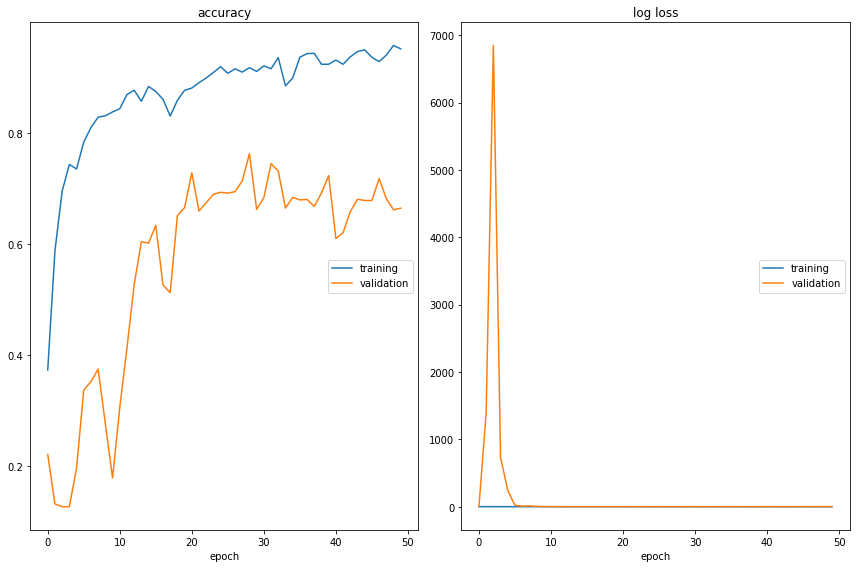

accuracy
	training         	 (min:    0.373, max:    0.958, cur:    0.951)
	validation       	 (min:    0.127, max:    0.763, cur:    0.664)
log loss
	training         	 (min:    0.123, max:    1.514, cur:    0.132)
	validation       	 (min:    0.924, max: 6847.065, cur:    2.006)
At epoch [21/50], get minimum validation loss: 0.9240


In [ ]:
# model_deeplabv3
model_deeplabv3 = create_segmentation_model().to(device)
#liveloss = PlotLosses()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deeplabv3.parameters(),lr=learning_rate,weight_decay=1e-3)

deeplabv3_resnet101_training_losses,deeplabv3_resnet101_training_accuracies,deeplabv3_resnet101_validation_losses,deeplabv3_resnet101_validation_accuracies = fit(model_deeplabv3,optimizer,criterion,train_loader,validation_loader,num_epochs,'deeplabv3_resnet101')

# Train Other Models  
https://pytorch.org/docs/stable/torchvision/models.html

In [ ]:
model_fcn_resnet50 = create_segmentation_model('FCN','Resnet50').to(device)

Creating FCN-resnet50...


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet50_coco-1167a1af.pth


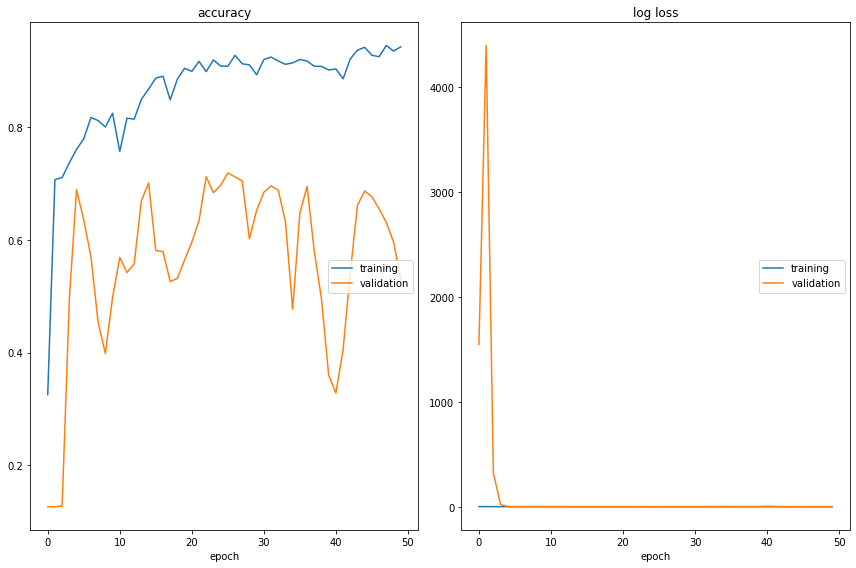

accuracy
	training         	 (min:    0.326, max:    0.945, cur:    0.943)
	validation       	 (min:    0.127, max:    0.719, cur:    0.531)
log loss
	training         	 (min:    0.148, max:    1.632, cur:    0.163)
	validation       	 (min:    0.844, max: 4400.466, cur:    1.546)
At epoch [26/50], get minimum validation loss: 0.8439


In [ ]:
# train FCN-Resnet50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fcn_resnet50.parameters(),lr=learning_rate,weight_decay=1e-3)

fcn_resnet50_training_losses,fcn_resnet50_training_accuracies,fcn_resnet50_validation_losses,fcn_resnet50_validation_accuracies = fit(model_fcn_resnet50,optimizer,criterion,train_loader,validation_loader,num_epochs,'fcn_resnet50')

# FCN_Resnet101

In [ ]:
model_fcn_resnet101 = create_segmentation_model('FCN','Resnet101').to(device)

Creating FCN-resnet101...


Downloading: "https://download.pytorch.org/models/fcn_resnet101_coco-7ecb50ca.pth" to /root/.cache/torch/hub/checkpoints/fcn_resnet101_coco-7ecb50ca.pth


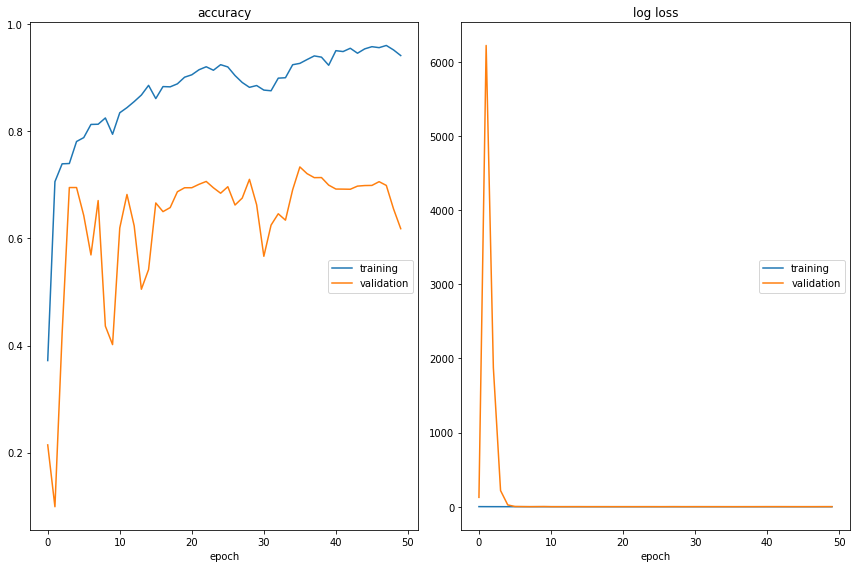

accuracy
	training         	 (min:    0.372, max:    0.960, cur:    0.941)
	validation       	 (min:    0.099, max:    0.733, cur:    0.618)
log loss
	training         	 (min:    0.106, max:    1.601, cur:    0.170)
	validation       	 (min:    0.867, max: 6220.979, cur:    1.466)
At epoch [12/50], get minimum validation loss: 0.8674


In [ ]:
# Train FCN-Resnet101
liveloss = PlotLosses()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_fcn_resnet101.parameters(),lr=learning_rate,weight_decay=1e-3)
fcn_resnet101_training_losses,fcn_resnet101_training_accuracies,fcn_resnet101_validation_losses,fcn_resnet101_validation_accuracies = fit(model_fcn_resnet101,optimizer,criterion,train_loader,validation_loader,num_epochs,'fcn_resnet101')

# DeepLabV3_resnet50

In [ ]:
model_deeplabv3_resnet50 = create_segmentation_model('DeepLabV3','Resnet50').to(device)

Creating DeepLabV3-resnet50...


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


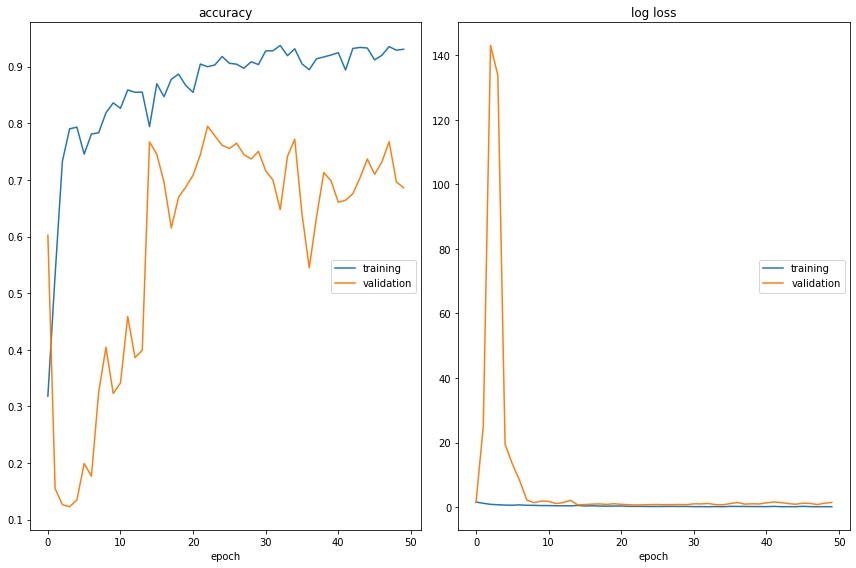

accuracy
	training         	 (min:    0.318, max:    0.937, cur:    0.931)
	validation       	 (min:    0.123, max:    0.795, cur:    0.686)
log loss
	training         	 (min:    0.171, max:    1.630, cur:    0.182)
	validation       	 (min:    0.719, max:  142.988, cur:    1.534)
At epoch [23/50], get minimum validation loss: 0.7194


In [ ]:
# Train DeepLabV3-Resnet50
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_deeplabv3_resnet50.parameters(),lr=learning_rate,weight_decay=1e-3)

deeplabv3_resnet50_training_losses,deeplabv3_resnet50_training_accuracies,deeplabv3_resnet50_validation_losses,deeplabv3_resnet50_validation_accuracies = fit(model_deeplabv3_resnet50,optimizer,criterion,train_loader,validation_loader,num_epochs,'deeplabv3_resnet50')

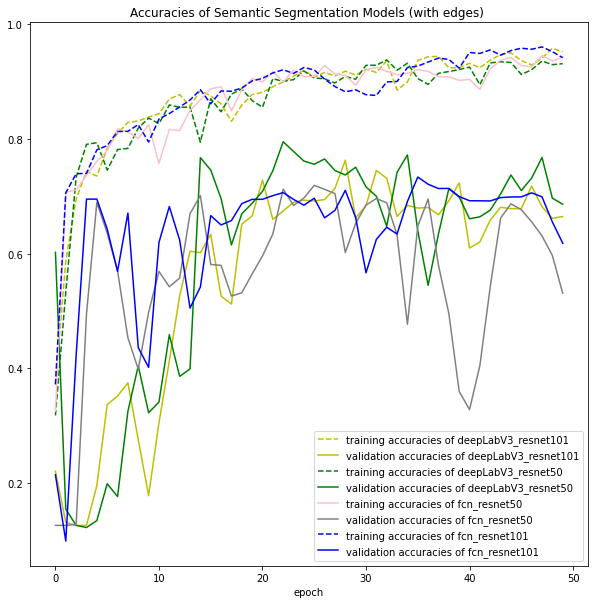

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(range(0,50),deeplabv3_resnet101_training_accuracies,'y--',label = 'training accuracies of deepLabV3_resnet101')
plt.plot(range(0,50),deeplabv3_resnet101_validation_accuracies,'y-',label = 'validation accuracies of deepLabV3_resnet101')
plt.plot(range(0,50),deeplabv3_resnet50_training_accuracies,'g--',label = 'training accuracies of deepLabV3_resnet50')
plt.plot(range(0,50),deeplabv3_resnet50_validation_accuracies,'g-',label = 'validation accuracies of deepLabV3_resnet50')
plt.plot(range(0,50),fcn_resnet50_training_accuracies,'pink',label = 'training accuracies of fcn_resnet50')
plt.plot(range(0,50),fcn_resnet50_validation_accuracies,'gray',label = 'validation accuracies of fcn_resnet50')
plt.plot(range(0,50),fcn_resnet101_training_accuracies,'b--',label = 'training accuracies of fcn_resnet101')
plt.plot(range(0,50),fcn_resnet101_validation_accuracies,'b-',label = 'validation accuracies of fcn_resnet101')

plt.title('Accuracies of Semantic Segmentation Models (with edges) ')
plt.xlabel('epoch')
plt.legend()

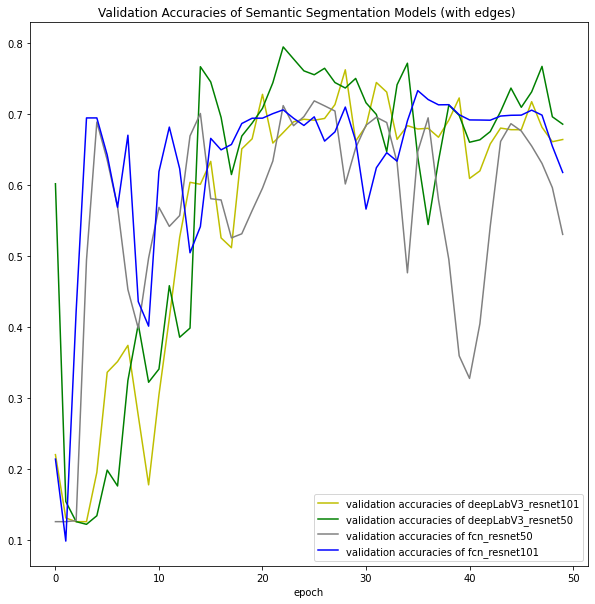

In [ ]:
plt.figure(figsize=(10,10))
#plt.plot(range(0,50),deeplabv3_resnet101_training_accuracies,'y--',label = 'training accuracies of deepLabV3_resnet101')
plt.plot(range(0,50),deeplabv3_resnet101_validation_accuracies,'y-',label = 'validation accuracies of deepLabV3_resnet101')
#plt.plot(range(0,50),deeplabv3_resnet50_training_accuracies,'g--',label = 'training accuracies of deepLabV3_resnet50')
plt.plot(range(0,50),deeplabv3_resnet50_validation_accuracies,'g-',label = 'validation accuracies of deepLabV3_resnet50')
#plt.plot(range(0,50),fcn_resnet50_training_accuracies,'pink',label = 'training accuracies of fcn_resnet50')
plt.plot(range(0,50),fcn_resnet50_validation_accuracies,'gray',label = 'validation accuracies of fcn_resnet50')
#plt.plot(range(0,50),fcn_resnet101_training_accuracies,'b--',label = 'training accuracies of fcn_resnet101')
plt.plot(range(0,50),fcn_resnet101_validation_accuracies,'b-',label = 'validation accuracies of fcn_resnet101')

plt.title('Validation Accuracies of Semantic Segmentation Models (with edges) ')
plt.xlabel('epoch')
plt.legend()